In [1]:
from pybaselines import Baseline, utils
import pandas as pd
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import pickle

from scipy.optimize import nnls
from numpy.linalg import norm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import glob

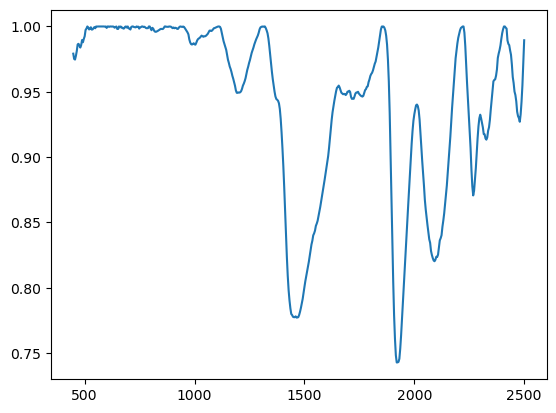

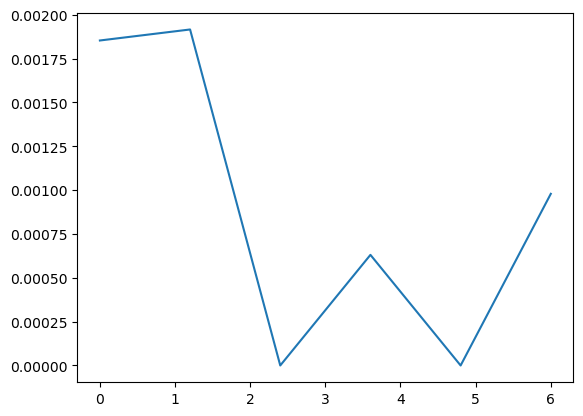

In [40]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')

# open a file, where you stored the pickled data
file = open('baseline_corrected_array.pickle', 'rb')

# dump information to that file
baseline_corrected_data = pickle.load(file)

# close the file
file.close()

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)


curr_spectrum = baseline_corrected_data[25,50,:]

plt.plot(wav_array, curr_spectrum)

# Master peak ranges
min_list = np.sort(np.asarray([820, 2490, 645, 790, 880, 1370, 1450, 1465, 1535, 1710, 1890, 1935, 2145, 2185, 2230, 2220, 2270, 2325, 2345, 2375]))
max_list = np.sort(np.asarray([980, 2550, 675, 810, 1150, 1420, 1490, 1500, 1565, 1785, 1940, 1960, 2185, 2230, 2265, 2300, 2330, 2370, 2390, 2415]))
mineral_label = ['iron oxides (goethite, hematite)', 'carbonates', 'molybdenite', 
                 'REE', 'pyroxene', 'micas, clays', 'jarosite', 'alunite', 
                 'epidote', 'sulphates', 'all OH, zeo', 'gypsum',
                 'pyrophyllite', 'Al-OH', 'chlorite, biotite', 'Al-fe smectites', 
                 'Fe-Mg smectites', 'chlorite, biotite', 'tourmaline', 'amphiboles, biotite']


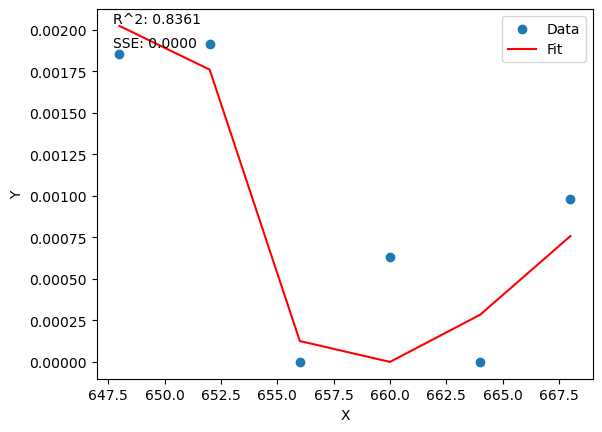

Optimization failed
Optimization failed


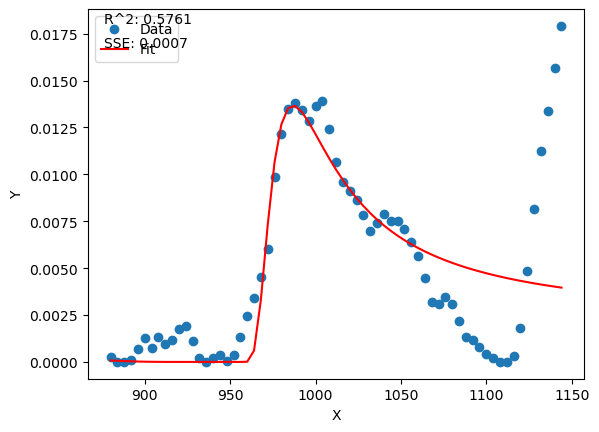

Optimization failed


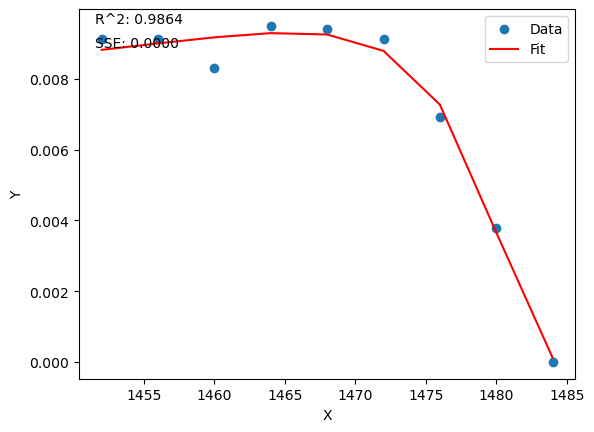

Optimization failed
Optimization failed
Optimization failed


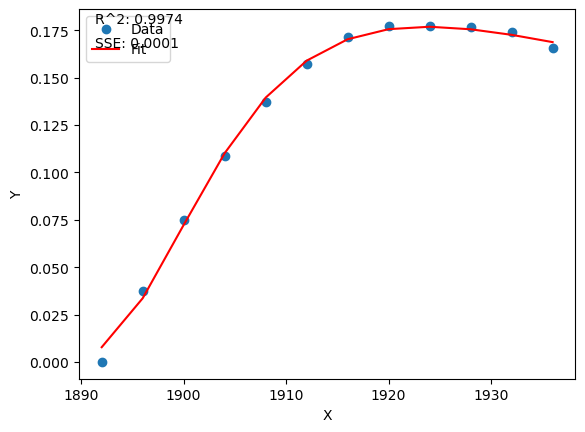

Optimization failed
Optimization failed
Optimization failed
Optimization failed


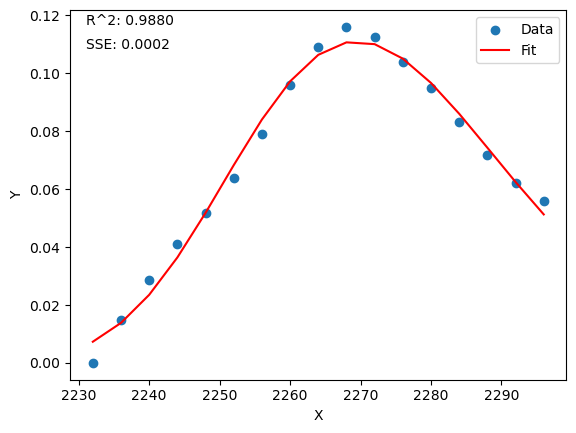

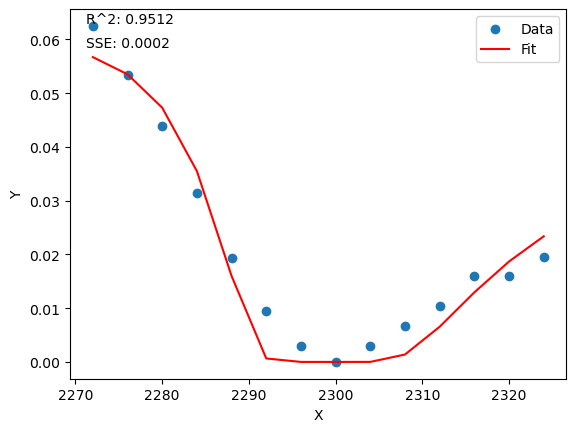

Optimization failed


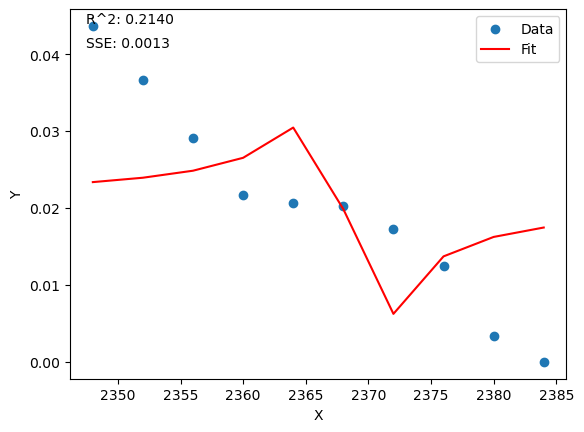

Optimization failed
Optimization failed


In [46]:
def compute_EGO_Gaussian(params, lmbda):
    # EGO Gaussian function 
    si, mu_i, sigma_i, k_i = params
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))


for i,k in enumerate(min_list):
# i = 0
    # curr_start = min_list[i]
    # curr_end = max_list[i]
    # int_array = wav_array[wav_array >= curr_start]
    # curr_wavs = int_array[int_array <= curr_end]
    
    curr_start = np.where(wav_array >= min_list[i])[0].min()
    curr_end = np.where(wav_array <= max_list[i])[0].max()
    
    curr_peak = (curr_spectrum[curr_start:curr_end])
    # Normalize the current peak
    curr_peak = curr_peak / curr_peak.max()
    curr_peak = 1 - curr_peak
    curr_wavs = wav_array[curr_start:curr_end]
    
    # Initial guess for the parameters
    initial_guess = [1, # Amplitude
                     np.mean(curr_wavs), # Position
                     np.std(curr_wavs), # Width
                     0.9] # Asymmetry]
    
    # Perform the curve fit
    try:
        params, params_covariance = curve_fit(compute_EGO_Gaussian,
                                              curr_wavs,
                                              curr_peak,
                                              p0=initial_guess,
                                              )
    except (RuntimeError, TypeError):
        print('Optimization failed')
        continue
    
    # Extract the fitted parameters
    si_fit, mu_i_fit, sigma_i_fit, k_i_fit = params
    
    # Generate the x-values for plotting
    x_values = np.linspace(min(curr_wavs), max(curr_wavs), curr_peak.shape[0])
    
    # Generate the y-values using the fitted parameters
    y_values = compute_EGO_Gaussian(x_values, si_fit, mu_i_fit, sigma_i_fit, k_i_fit)
    
    # Plot the original data and the fitted curve
    plt.figure()
    # plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
    #           curr_peak)
    plt.scatter(curr_wavs, curr_peak, label='Data')
    plt.plot(x_values, y_values, 'r-', label='Fit')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    # calculate r_squared and SSE        
    residuals = curr_peak - y_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((curr_peak-np.mean(curr_peak))**2)
    r_squared = 1 - (ss_res / ss_tot)
    sse = np.sum((curr_peak - y_values)**2)
    
    # Here we should prepare to re-do the optimization if we don't hit
    # a reasonable R2 threshold
    # We should also consider an optimization step here, 
    # Bayesian hyperparam or grid search, that would 
    # allow us to guarantee the best fit
    # fig = plt.figure()
    # plt.plot(curr_wavs, curr_peak)
    # plt.plot(curr_wavs, y_values , 'r-')
    # add the metrics to the plot
    plt.figtext(0.15, 0.85, 'R^2: {:.4f}'.format(r_squared))
    plt.figtext(0.15, 0.80, 'SSE: {:.4f}'.format(sse))
    
    plt.show()


Optimization failed
Optimization failed
Optimization failed
Optimization failed
Optimization failed


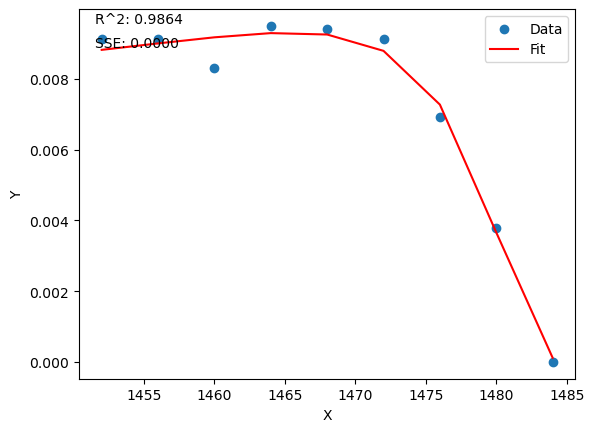

Optimization failed
Optimization failed
Optimization failed


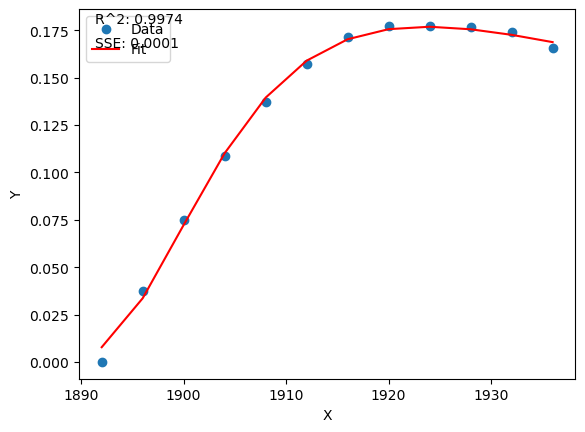

Optimization failed
Optimization failed
Optimization failed


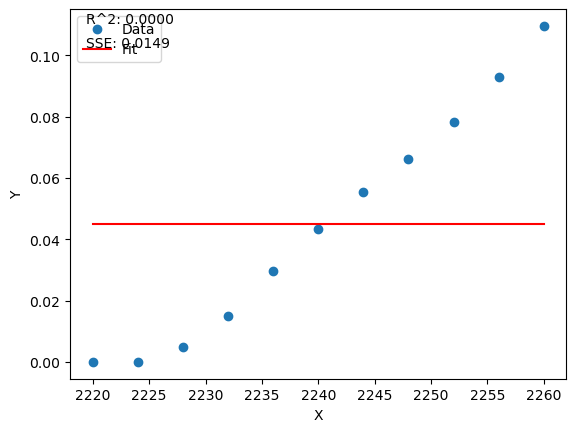

Optimization failed


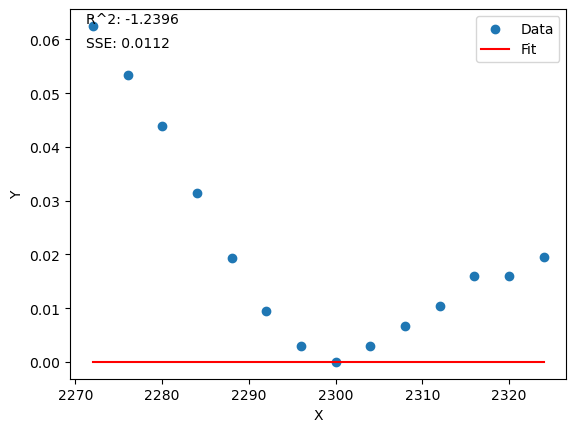

Optimization failed
Optimization failed
Optimization failed
Optimization failed


In [53]:
def compute_EGO_Gaussian(params, lmbda):
    # EGO Gaussian function 
    si, mu_i, sigma_i, k_i = params
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def compute_EGO_Gaussian(lmbda, si, mu_i, sigma_i, k_i):
    # EGO Gaussian function
    return si * np.exp(-0.5 * ((lmbda - mu_i) ** 2 / (sigma_i - k_i * (lmbda - mu_i)) ** 2))

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

def weighted_sum_EGO_Gaussians(x, *params):
    num_peaks = len(params) // 4
    result = np.zeros_like(x)
    for i in range(num_peaks):
        si, mu_i, sigma_i, k_i = params[i*4 : (i+1)*4]
        result += compute_EGO_Gaussian(x, si, mu_i, sigma_i, k_i)
    return result

# guess = [2100, 1, 10, 
#          2275, 1, 10]
# # for i in range(12):
# #     guess += [60+80*i, 46000, 25]

# popt, pcov = curve_fit(func, curr_wavs, curr_peak, p0=guess)
# fit = func(curr_wavs, *popt)


for i,k in enumerate(min_list):
# i = 0
    # curr_start = min_list[i]
    # curr_end = max_list[i]
    # int_array = wav_array[wav_array >= curr_start]
    # curr_wavs = int_array[int_array <= curr_end]
    
    curr_start = np.where(wav_array >= min_list[i])[0].min()
    curr_end = np.where(wav_array <= max_list[i])[0].max()
    
    curr_peak = (curr_spectrum[curr_start:curr_end])
    # Normalize the current peak
    curr_peak = curr_peak / curr_peak.max()
    curr_peak = 1 - curr_peak
    curr_wavs = wav_array[curr_start:curr_end]
    
    # Initial guess for the parameters
    initial_guess = [1, # Amplitude
                     np.mean(curr_wavs)/2, # Position
                     np.std(curr_wavs), # Width
                     0.9, # Asymmetry
                     1, # Amplitude
                     (np.mean(curr_wavs)/2)*3, # Position
                     np.std(curr_wavs), # Width
                     0.9, # Asymmetry
                    ] 
    
    # Perform the curve fit
    try:
        params, params_covariance = curve_fit(weighted_sum_EGO_Gaussians,
                                              curr_wavs,
                                              curr_peak,
                                              p0=initial_guess,
                                              )
    except (RuntimeError, TypeError):
        print('Optimization failed')
        continue
    
    # Extract the fitted parameters
    # si_fit, mu_i_fit, sigma_i_fit, k_i_fit = params
    
    # Generate the x-values for plotting
    x_values = np.linspace(min(curr_wavs), max(curr_wavs), curr_peak.shape[0])
    
    # Generate y-values for the fitted curve using the obtained parameters
    y_values = weighted_sum_EGO_Gaussians(x_values, *params)
    
    # Plot the original data and the fitted curve
    plt.figure()
    # plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
    #           curr_peak)
    plt.scatter(curr_wavs, curr_peak, label='Data')
    plt.plot(x_values, y_values, 'r-', label='Fit')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    
    # calculate r_squared and SSE        
    residuals = curr_peak - y_values
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((curr_peak-np.mean(curr_peak))**2)
    r_squared = 1 - (ss_res / ss_tot)
    sse = np.sum((curr_peak - y_values)**2)
    
    # Here we should prepare to re-do the optimization if we don't hit
    # a reasonable R2 threshold
    # We should also consider an optimization step here, 
    # Bayesian hyperparam or grid search, that would 
    # allow us to guarantee the best fit
    # fig = plt.figure()
    # plt.plot(curr_wavs, curr_peak)
    # plt.plot(curr_wavs, y_values , 'r-')
    # add the metrics to the plot
    plt.figtext(0.15, 0.85, 'R^2: {:.4f}'.format(r_squared))
    plt.figtext(0.15, 0.80, 'SSE: {:.4f}'.format(sse))
    
    plt.show()
